In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from skimpy import skim
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster 
from scipy.spatial.distance import pdist, squareform 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df= pd.read_csv(r'/data/OnlineNewsPopularity.csv')

df_clean=df.copy()

#Cleaning column names
df_clean.columns= [c.strip() for c in df.columns.values.tolist()]
df_clean=df_clean.drop(columns=['LDA_00','LDA_01','LDA_02','LDA_03','LDA_04'])

#There are no NA values 
df_clean.isna().sum()



url                              0
timedelta                        0
n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
kw_max_min                       0
kw_avg_min                       0
kw_min_max                       0
kw_max_max                       0
kw_avg_max                       0
kw_min_avg                       0
kw_max_avg                       0
kw_avg_avg                       0
self_reference_min_s

In [4]:

df2=df_clean.copy()

#Creating week column 
#Melting weekday columns
melt_cols=['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday','weekday_is_thursday','weekday_is_friday','weekday_is_saturday','weekday_is_sunday']
id_cols=[c for c in df2.columns.tolist() if c not in melt_cols] #List of columns to not melt together

df2=pd.melt(df2,
            id_vars=id_cols,
            value_vars=melt_cols,
            var_name='weekday',
            value_name='weekday_value')

#Filter for rows to remove unnecessary values
df2=df2[df2.weekday_value!=0]

#Creating a function to extract specific names from values
def splitter(string,symbol):
    text_list=string.split(symbol)
    length=len(text_list)- 1
    return text_list[length]

#Getting the weekday name from the weekday_name column
df2['weekday_name']=df2['weekday'].apply(splitter, args='_')


#Creating topic column
#Melting topic columns together
melt_cols2=['data_channel_is_lifestyle','data_channel_is_entertainment','data_channel_is_bus','data_channel_is_socmed','data_channel_is_tech','data_channel_is_world']
id_cols2=[c for c in df2.columns.tolist() if c not in melt_cols2] #List of columns to not melt together

df2=pd.melt(df2,
            id_vars=id_cols2,
            value_vars=melt_cols2,
            var_name='topic',
            value_name='topic_value')

#Filter for rows to remove unnecessary values
df2=df2[df2.topic_value!=0]

#Getting topic name from the topic_name column
df2['topic_name']=df2['topic'].apply(splitter, args='_')

#Dropping unnecessary columns
df2=df2.drop(columns={'weekday_value','weekday','topic','topic_value'}).rename(columns={'weekday_name':'weekday','topic_name':'topic'})

In [5]:
#Creating viral column (an article is viral when it gets more than 1400 shares)

upper_bound=np.percentile(df2['shares'],75)
lower_bound=np.percentile(df2['shares'],25)
iqr=upper_bound-lower_bound

df2['viral']=np.where(df2['shares']>1400,1,0)

df2[df2['viral']==1].shape

(15827, 46)

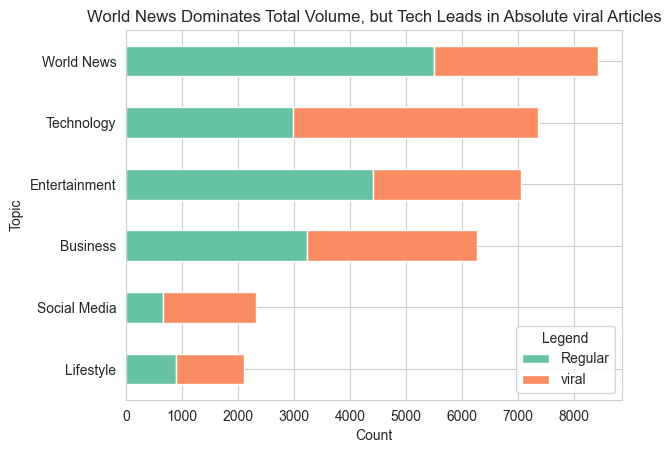

In [6]:
#Creating bar chart for viral vs. regular articles by topic
#Grouping data by topic and aggregating by count
df4=(df2.groupby(['topic','viral'])['url']
     .count()
     .sort_values(ascending=False)
     .reset_index())

#Transforming the data
df4=(df4.pivot(index='topic',columns='viral',values='url')
     .reset_index()
     .rename(columns={0:'regular',1:'viral'}))

df4['total']=df4['regular']+df4['viral'] #Getting total counts by summing counts of regular and viral articles
df4=df4.sort_values(by='total', ascending=False)

totals=df4[['topic','total']]
df4=df4.drop(columns='total')

#Getting colour map
cmap=plt.colormaps['Set2']
color1=cmap.colors[0]
color2=cmap.colors[1]
colors=[color1,color2]

#Plotting Graph
sns.set_style("whitegrid")
labs=['World News','Technology','Entertainment','Business','Social Media','Lifestyle']

fig= df4.set_index('topic').plot(kind='barh',stacked=True,color=colors)
fig.invert_yaxis()
plt.title('World News Dominates Total Volume, but Tech Leads in Absolute viral Articles')
plt.legend(title='Legend',labels=['Regular','viral'])
plt.ylabel('Topic')
fig.set_yticklabels(labs)
plt.xlabel('Count')
plt.show()


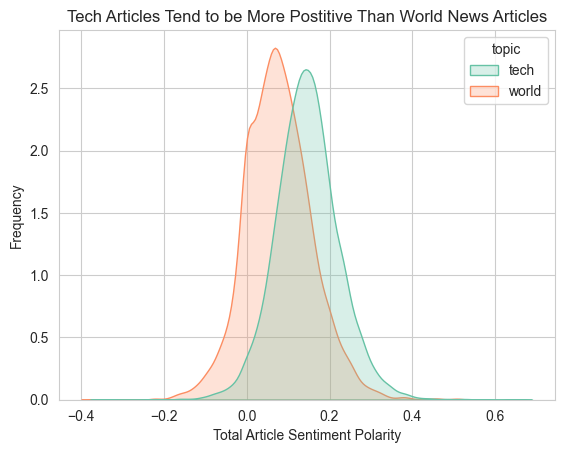

In [7]:
#Creating sentiment KDE plot
df5=df2.copy()

#Filtering for world and tech articles
sns.set_style("whitegrid")
df5=df5[df5['topic'].isin(['world','tech'])]

sns.kdeplot(df5,x='global_sentiment_polarity',hue='topic',fill=True,palette='Set2')
plt.title("Tech Articles Tend to be More Postitive Than World News Articles")
plt.xlabel("Total Article Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

/var/folders/85/8clyf79s3t3d0dzbfvhq0b8w0000gn/T/ipykernel_35351/4049337259.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(labs)


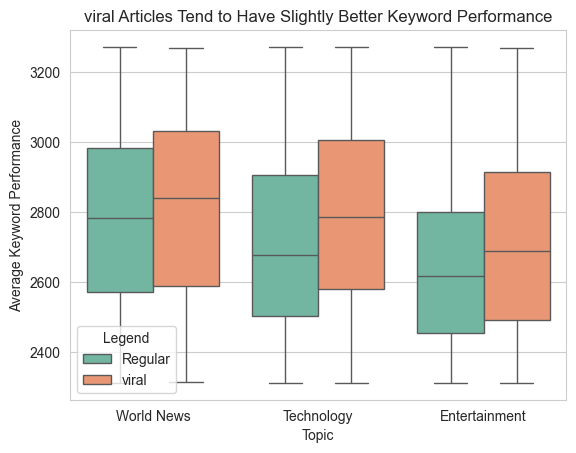

In [8]:
df6=df2.copy()

#Removing Outliers
upper_bound=np.percentile(df6['kw_avg_avg'],75)
lower_bound=np.percentile(df6['kw_avg_avg'],25)
iqr=upper_bound-lower_bound

upperbound=np.percentile(df6['kw_avg_avg'],75)+1.5*iqr
lowerbound=np.percentile(df6['kw_avg_avg'],25)-1.5*iqr

df6 = df6[
    (df6['kw_avg_avg'] >= lower_bound) &
    (df6['kw_avg_avg'] <= upper_bound) #Filter data within the upper and lower bounds
]

#Filtering for top 3 topics
df6=df6[df6['topic'].isin(['world','tech','entertainment'])]

#Plotting box plot
fig=sns.boxplot(data=df6,hue='viral',y='kw_avg_avg',x='topic',palette='Set2')

legend =plt.legend(loc='lower left')

labs=['World News','Technology','Entertainment']

plt.ylabel("Average Keyword Performance")
plt.xlabel("Topic")
legend.set_title("Legend")
legend.texts[0].set_text('Regular')
legend.texts[1].set_text('viral')
fig.set_xticklabels(labs)
plt.title("viral Articles Tend to Have Slightly Better Keyword Performance")
plt.show()

<Axes: xlabel='shares', ylabel='topic'>

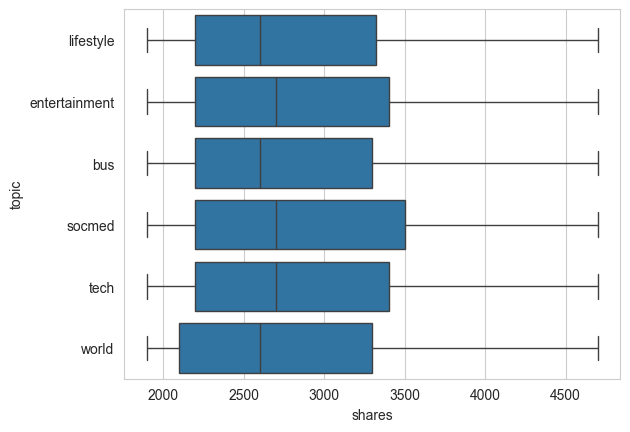

In [9]:
#Creating viral dataset for articles that are viral
df_viral=df2[df2['viral']==1].copy().reset_index()

upper_bound=np.percentile(df_viral['shares'],75)
lower_bound=np.percentile(df_viral['shares'],25)
iqr=upper_bound-lower_bound

upperbound=np.percentile(df_viral['shares'],75)+1.5*iqr
lowerbound=np.percentile(df_viral['shares'],25)-1.5*iqr

df_viral = df_viral[
    (df_viral['shares'] >= lower_bound) &
    (df_viral['shares'] <= upper_bound)
]

sns.boxplot(df_viral,x='shares',y='topic')

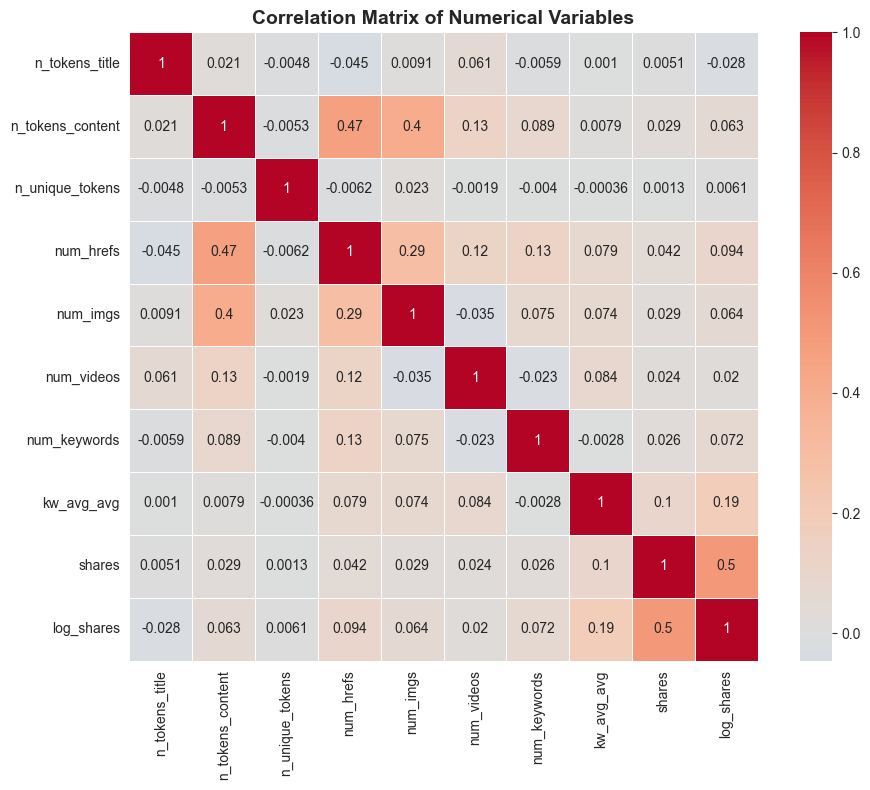

In [10]:
#Getting Numerical values only
df_num=df2.copy()
df_num=df_num[['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
    'num_hrefs', 'num_imgs', 'num_videos', 
    'num_keywords', 'kw_avg_avg', 'shares']]

df_num['log_shares']=np.log(df_num['shares'])

# Create correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_num.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
df_cluster=df_viral.copy()

drop_cols=['weekday','topic','url','shares','index']

df_cluster_cols=[c for c in df_cluster.columns.tolist() if c not in drop_cols]
df_cluster=df_cluster[df_cluster_cols]
print(df_cluster_cols)

scaler = StandardScaler()

df_scaled=scaler.fit_transform(df_cluster)
df_scaled=pd.DataFrame(df_scaled, columns= df_cluster_cols)

['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'is_weekend', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity', 'viral']


[8026  120]


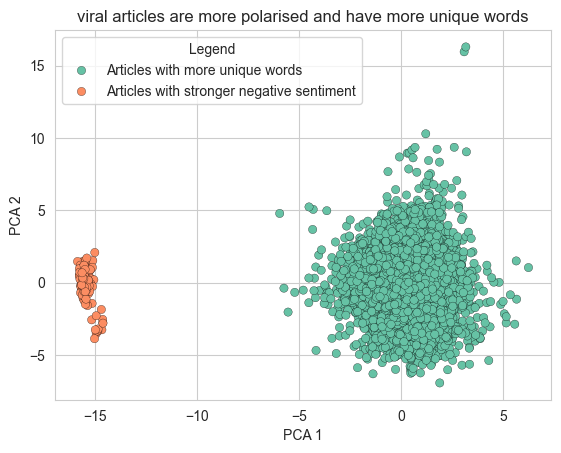

In [12]:


#Creating clusters using K-means clustering
cluster_news=KMeans(n_clusters=2, n_init=50, random_state=69).fit(df_scaled)
cluster_news_labels=cluster_news.labels_
unique, counts = np.unique(cluster_news_labels, return_counts=True)

print(counts)

#Dimension reduction for visualisation via PCA

pca=PCA(2, random_state=69)
cluster_pca= pca.fit_transform(df_scaled.values) #Reducing multidimensional data to 2 dimensions

pca1=np.array(cluster_pca[:,0]) #Extracting PCA 1
pca2=np.array(cluster_pca[:,1]) #Extracting PCA 2

#Ploting graph
sns.set_style("whitegrid")
sns.scatterplot(x=pca1,y=pca2,hue=cluster_news_labels,palette='Set2',linewidth=0.2, edgecolor='black')
plt.title("viral articles are more polarised and have more unique words")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

legend =plt.legend()
legend.set_title("Legend")
legend.texts[0].set_text('Articles with more unique words')
legend.texts[1].set_text('Articles with stronger negative sentiment')
plt.show()

In [13]:
#Checking articles in each cluster
#Cluster 1: Articles with more unique words
#Cluster 2: Articles with greater negative sentiment
df_viral2=df_viral.copy()
pd.set_option('display.max_colwidth', None)

df_viral2['k_clusters']=cluster_news_labels
df_viral2[df_viral2['k_clusters']==1]['url']

162                      http://mashable.com/2014/10/25/resume-hard-truths/
189                    http://mashable.com/2013/02/05/online-dating-habits/
191         http://mashable.com/2013/02/05/teachers-technology-infographic/
345                  http://mashable.com/2014/11/10/shake-up-daily-routine/
550      http://mashable.com/2014/11/04/st-louis-county-ran-out-of-ballots/
                                        ...                                
15672                      http://mashable.com/2014/04/12/shots-selfie-app/
15676                    http://mashable.com/2014/04/13/must-reads-4-13-14/
15761            http://mashable.com/2014/09/27/climate-change-stats-video/
15789                   http://mashable.com/2014/11/07/french-fries-pop-up/
15824                   http://mashable.com/2014/12/24/drake-holiday-cards/
Name: url, Length: 120, dtype: object

In [14]:
sil_avgs={}
for k in [2, 3, 4, 5,6,7]:
    # Run K-Means with k clusters
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(df_scaled)
    labels = km.labels_  # Get cluster labels

    # Calculate average silhouette score
    # silhouette_score calculates the average for all points
    sil = silhouette_score(df_scaled, labels)
    sil_avgs[k] = sil  # Store the score

    # Print the result
    print(f"k={k}: Average silhouette score = {sil:.3f}")

k=2: Average silhouette score = 0.567
k=3: Average silhouette score = 0.082
k=4: Average silhouette score = 0.090
k=5: Average silhouette score = 0.094
k=6: Average silhouette score = 0.093
k=7: Average silhouette score = 0.095


Testing k values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

k= 1: WSS = 333,986.00
k= 2: WSS = 301,172.76
k= 3: WSS = 281,549.48
k= 4: WSS = 264,597.98
k= 5: WSS = 251,668.36
k= 6: WSS = 240,198.58
k= 7: WSS = 230,425.36
k= 8: WSS = 220,987.06
k= 9: WSS = 215,556.75
k=10: WSS = 209,798.27



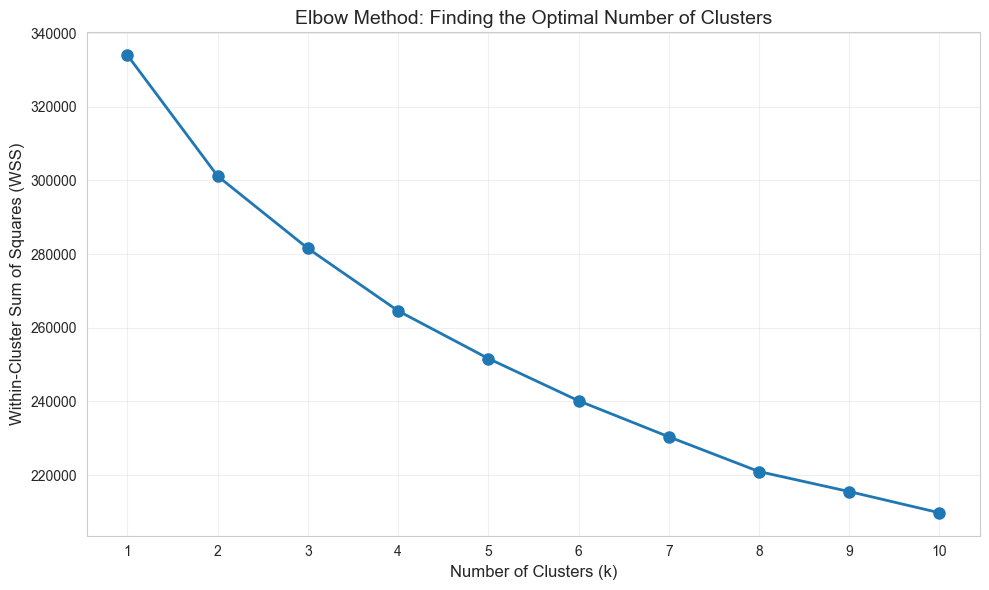

CHANGE IN WSS (helping find the elbow):
k=1 to k=2: WSS decreased by 32,813.24 (9.8%)
k=2 to k=3: WSS decreased by 19,623.28 (6.5%)
k=3 to k=4: WSS decreased by 16,951.49 (6.0%)
k=4 to k=5: WSS decreased by 12,929.62 (4.9%)
k=5 to k=6: WSS decreased by 11,469.78 (4.6%)
k=6 to k=7: WSS decreased by 9,773.22 (4.1%)
k=7 to k=8: WSS decreased by 9,438.29 (4.1%)
k=8 to k=9: WSS decreased by 5,430.32 (2.5%)
k=9 to k=10: WSS decreased by 5,758.47 (2.7%)



In [15]:

# We'll try k from 1 to 10
ks = list(range(1, 11))  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(f"Testing k values: {ks}")
print()

# STEP 2: Calculate WSS for each value of k
# WSS = Within-cluster Sum of Squares (how tight the clusters are)
# Lower WSS = tighter clusters (better)
sse = []  # List to store WSS values

for k in ks:
    # Run K-Means with k clusters
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(df_scaled)

    # Get the WSS (inertia_ is the WSS)
    wss = km.inertia_
    sse.append(wss)

    print(f"k={k:2d}: WSS = {wss:,.2f}")

print()

# STEP 3: Create the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(ks, sse, marker='o', linewidth=2, markersize=8)  # Plot WSS vs k
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
plt.title('Elbow Method: Finding the Optimal Number of Clusters', fontsize=14)
plt.xticks(ks)  # Show all k values on x-axis
plt.grid(True, alpha=0.3)  # Add grid for easier reading
plt.tight_layout()  # Adjust spacing
plt.show()  # Display the plot

# STEP 4: Calculate and show the "elbow" (change in WSS)
print("=" * 60)
print("CHANGE IN WSS (helping find the elbow):")
print("=" * 60)
for i in range(1, len(sse)):
    change = sse[i-1] - sse[i]  # How much WSS decreased
    percent_change = (change / sse[i-1]) * 100  # Percentage decrease
    print(f"k={i} to k={i+1}: WSS decreased by {change:,.2f} ({percent_change:.1f}%)")
print()


In [16]:

hc_k = 2  # match the lecture default for easy comparison

# STEP 1: Pairwise Euclidean distances (condensed vector form)
distance_condensed = pdist(df_scaled, metric="euclidean")

# STEP 2: Ward linkage dendrogram (minimises increase in within-cluster variance)
hc_linkage = linkage(distance_condensed, method="ward")

# STEP 3: Cut the dendrogram to obtain flat clusters
ehc_labels = fcluster(hc_linkage, t=hc_k, criterion="maxclust")

# STEP 4: Summaries and diagnostics
cluster_sizes = np.bincount(ehc_labels, minlength=hc_k + 1)[1:]
print(cluster_sizes)

[ 120 8026]


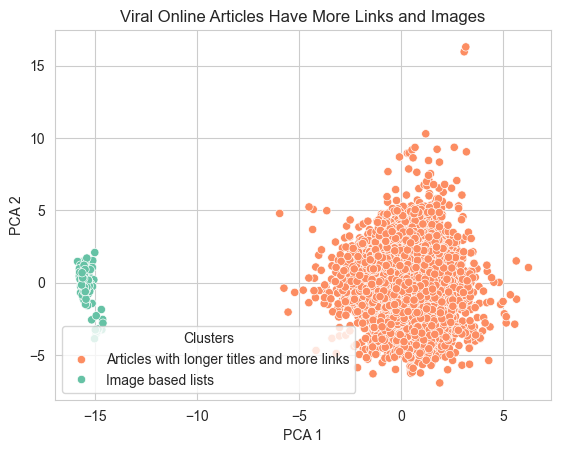

In [17]:
pca=PCA(2, random_state=69)
cluster_pca= pca.fit_transform(df_scaled.values)

pca1=np.array(cluster_pca[:,0])
pca2=np.array(cluster_pca[:,1])

sns.scatterplot(x=pca1,y=pca2,hue=ehc_labels,palette='Set2')

plt.title("Viral Online Articles Have More Links and Images")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Clusters', 
           loc='lower left', 
           labels=['Articles with longer titles and more links','Image based lists']
           )
plt.show()

In [26]:
# ============================
# CLUSTER PROFILES – HEATMAP (LOG SCALE) WITH HUMAN-FRIENDLY LABELS
# ============================


# 0) Mapping from original variable names → human-friendly descriptive labels
friendly_names = {
    "self_reference_max_shares": "Max shares of linked Mashable articles",
    "self_reference_avg_sharess": "Avg shares of linked Mashable articles",
    "self_reference_min_shares": "Min shares of linked Mashable articles",
    "n_tokens_content": "Number of words in article",
    "num_hrefs": "Number of hyperlinks",
    "average_token_length": "Avg word length",
    "num_self_hrefs": "Number of self hyperlinks",
    "min_negative_polarity": "Most negative sentiment score",
    "n_non_stop_words": "Non-stopword count",
    "max_positive_polarity": "Most positive sentiment score",
    "rate_positive_words": "Rate of positive words",
    "n_non_stop_unique_tokens": "Unique meaningful tokens",
    "num_imgs": "Number of images",
    "kw_min_min": "Min keyword virality",
    "kw_avg_max": "Avg keyword max virality",
    "kw_max_max": "Max keyword max virality",
    "kw_min_max": "Max keyword min virality",
    "kw_avg_avg": "Avg keyword virality",
    "kw_max_avg": "Avg max keyword pop.",
    "kw_max_min": "Min keyword max virality",
    "kw_avg_min": "Min avg keyword virality",
    "kw_min_avg": "Avg min keyword virality",
    "timedelta": "Age of article (days)"
}



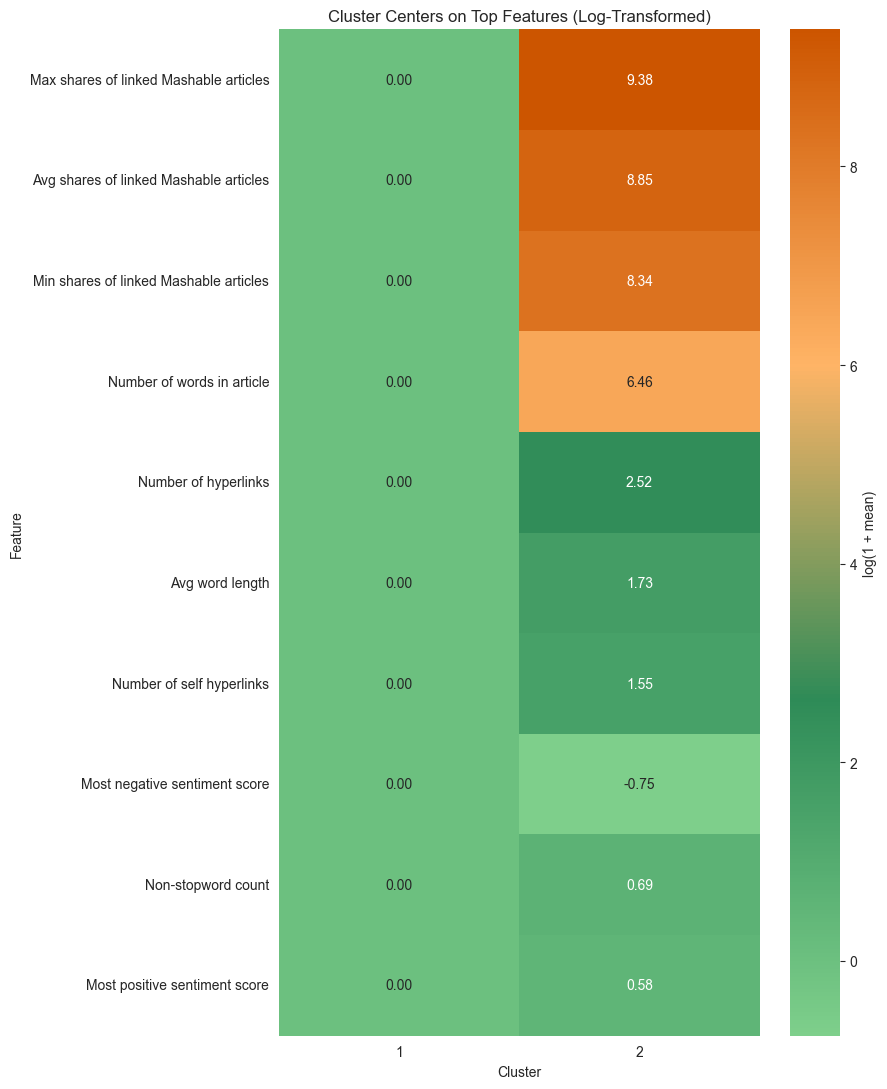

In [27]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Two separate gradients merged into one colormap
green_gradient  = ["#7ecf8b", "#2e8b57"]   # light green → dark green
orange_gradient = ["#ffb466", "#cc5500"]   # light orange → dark orange

# Combine (first half = green, second half = orange)
colors = green_gradient + orange_gradient
custom_cmap = LinearSegmentedColormap.from_list("split_cmap", colors, N=256)

plt.figure(figsize=(9, 11))

sns.heatmap(
    hc_log_top_friendly.T,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    cbar_kws={"label": "log(1 + mean)"},
)

plt.title("Cluster Centers on Top Features (Log-Transformed)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Shape of X: (33510, 52)
Shape of y: (33510,)
Random Forest fitted!
Train accuracy: 0.866868099074903
Test accuracy: 0.6789018203521336

Classification report:

              precision    recall  f1-score   support

     Regular       0.68      0.73      0.71      3537
       viral       0.67      0.62      0.65      3165

    accuracy                           0.68      6702
   macro avg       0.68      0.68      0.68      6702
weighted avg       0.68      0.68      0.68      6702

Confusion matrix:

[[2585  952]
 [1200 1965]]


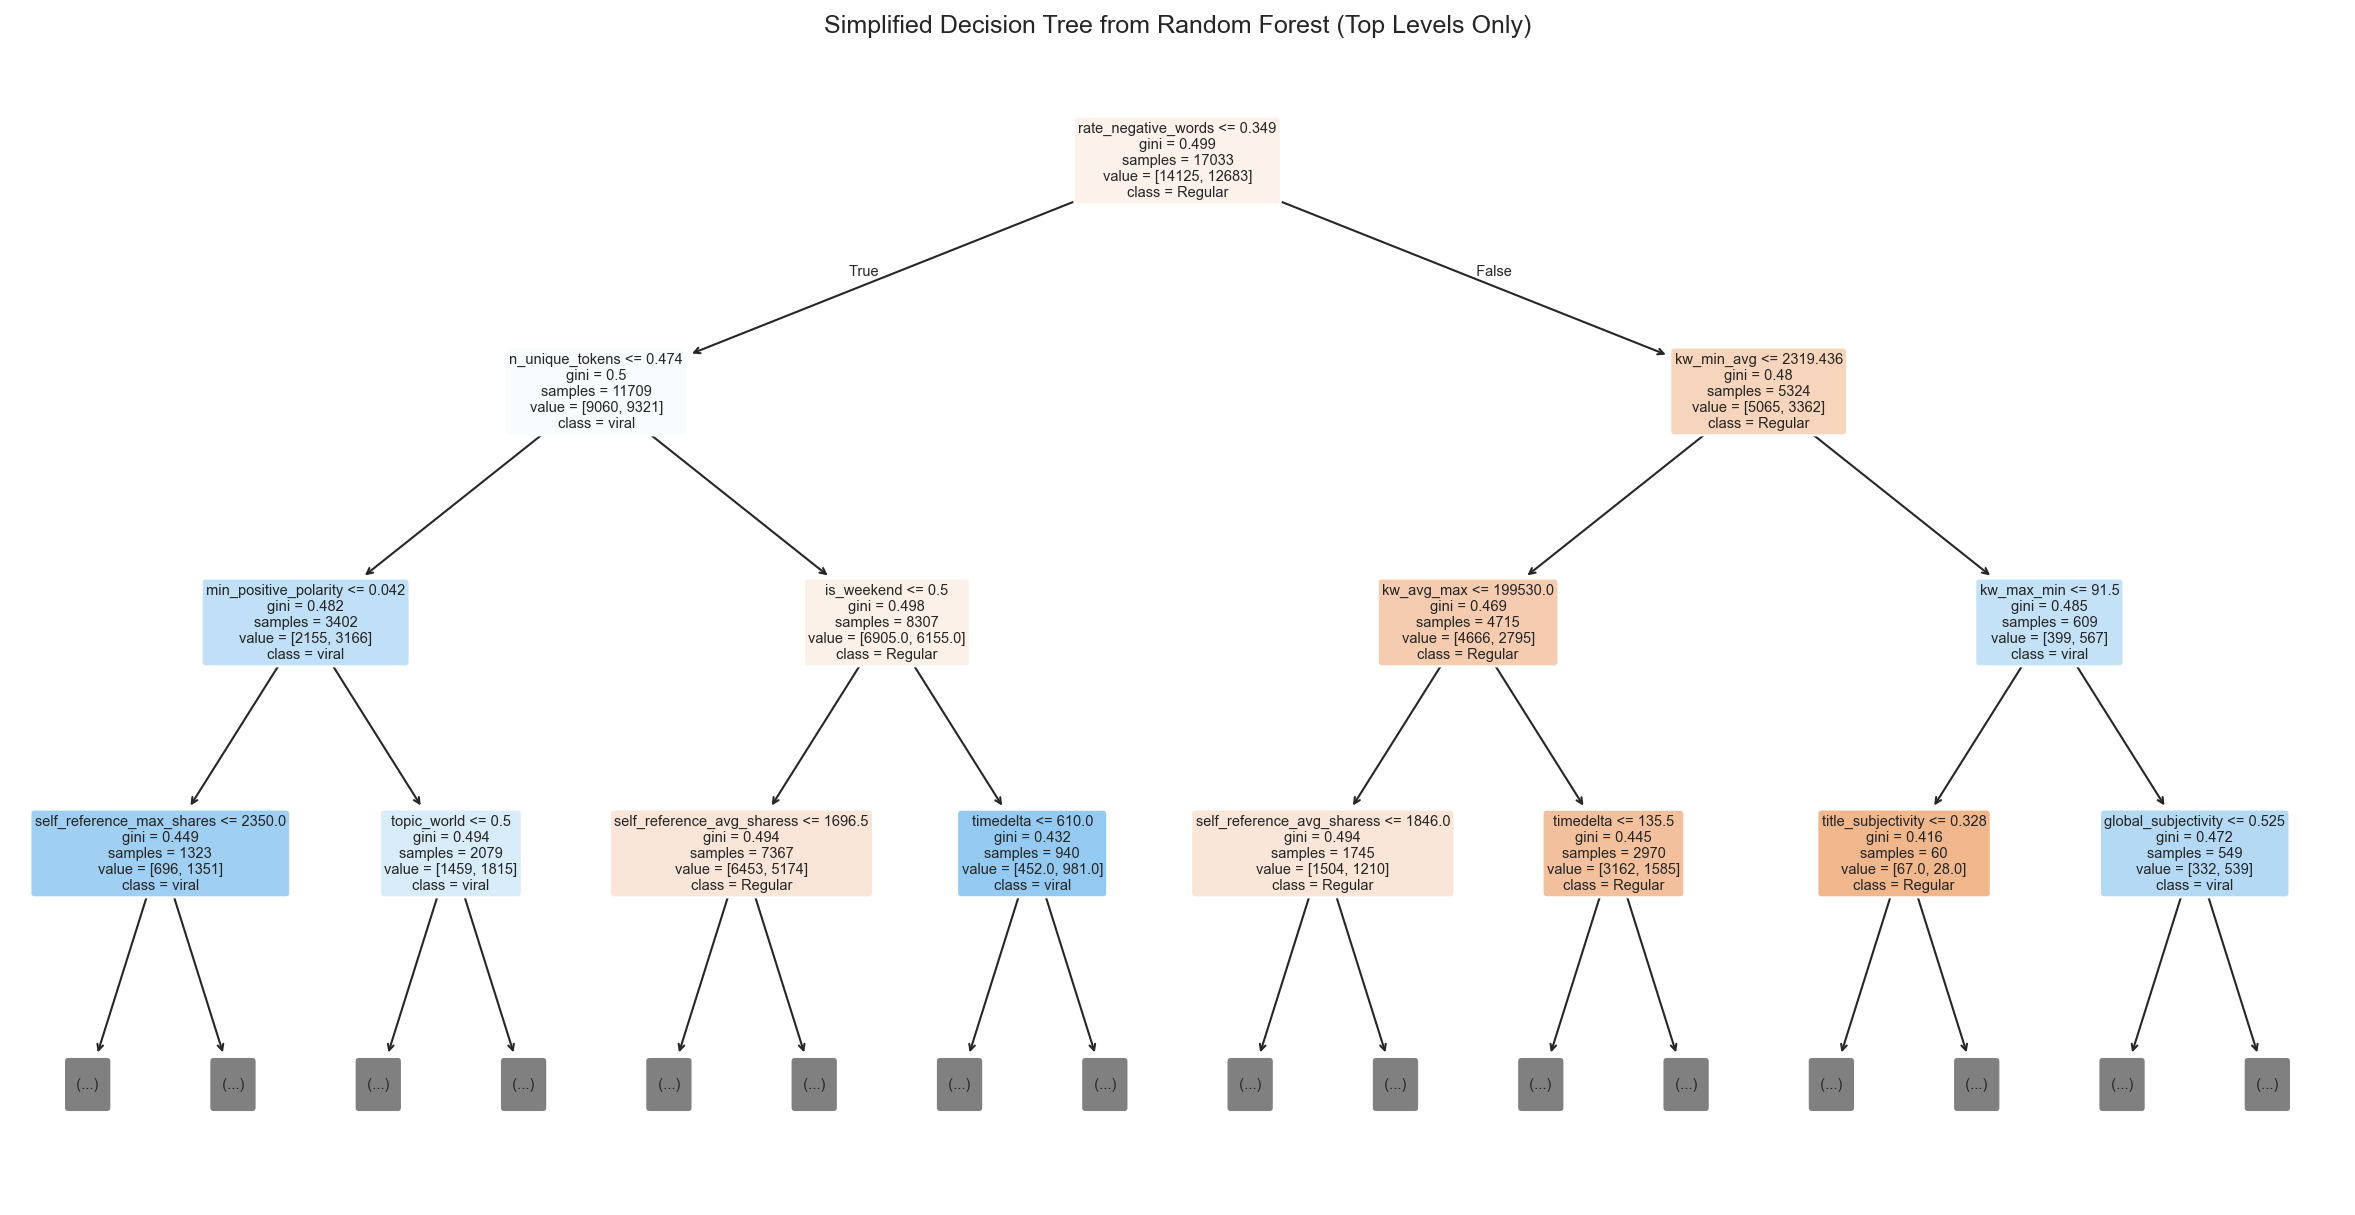

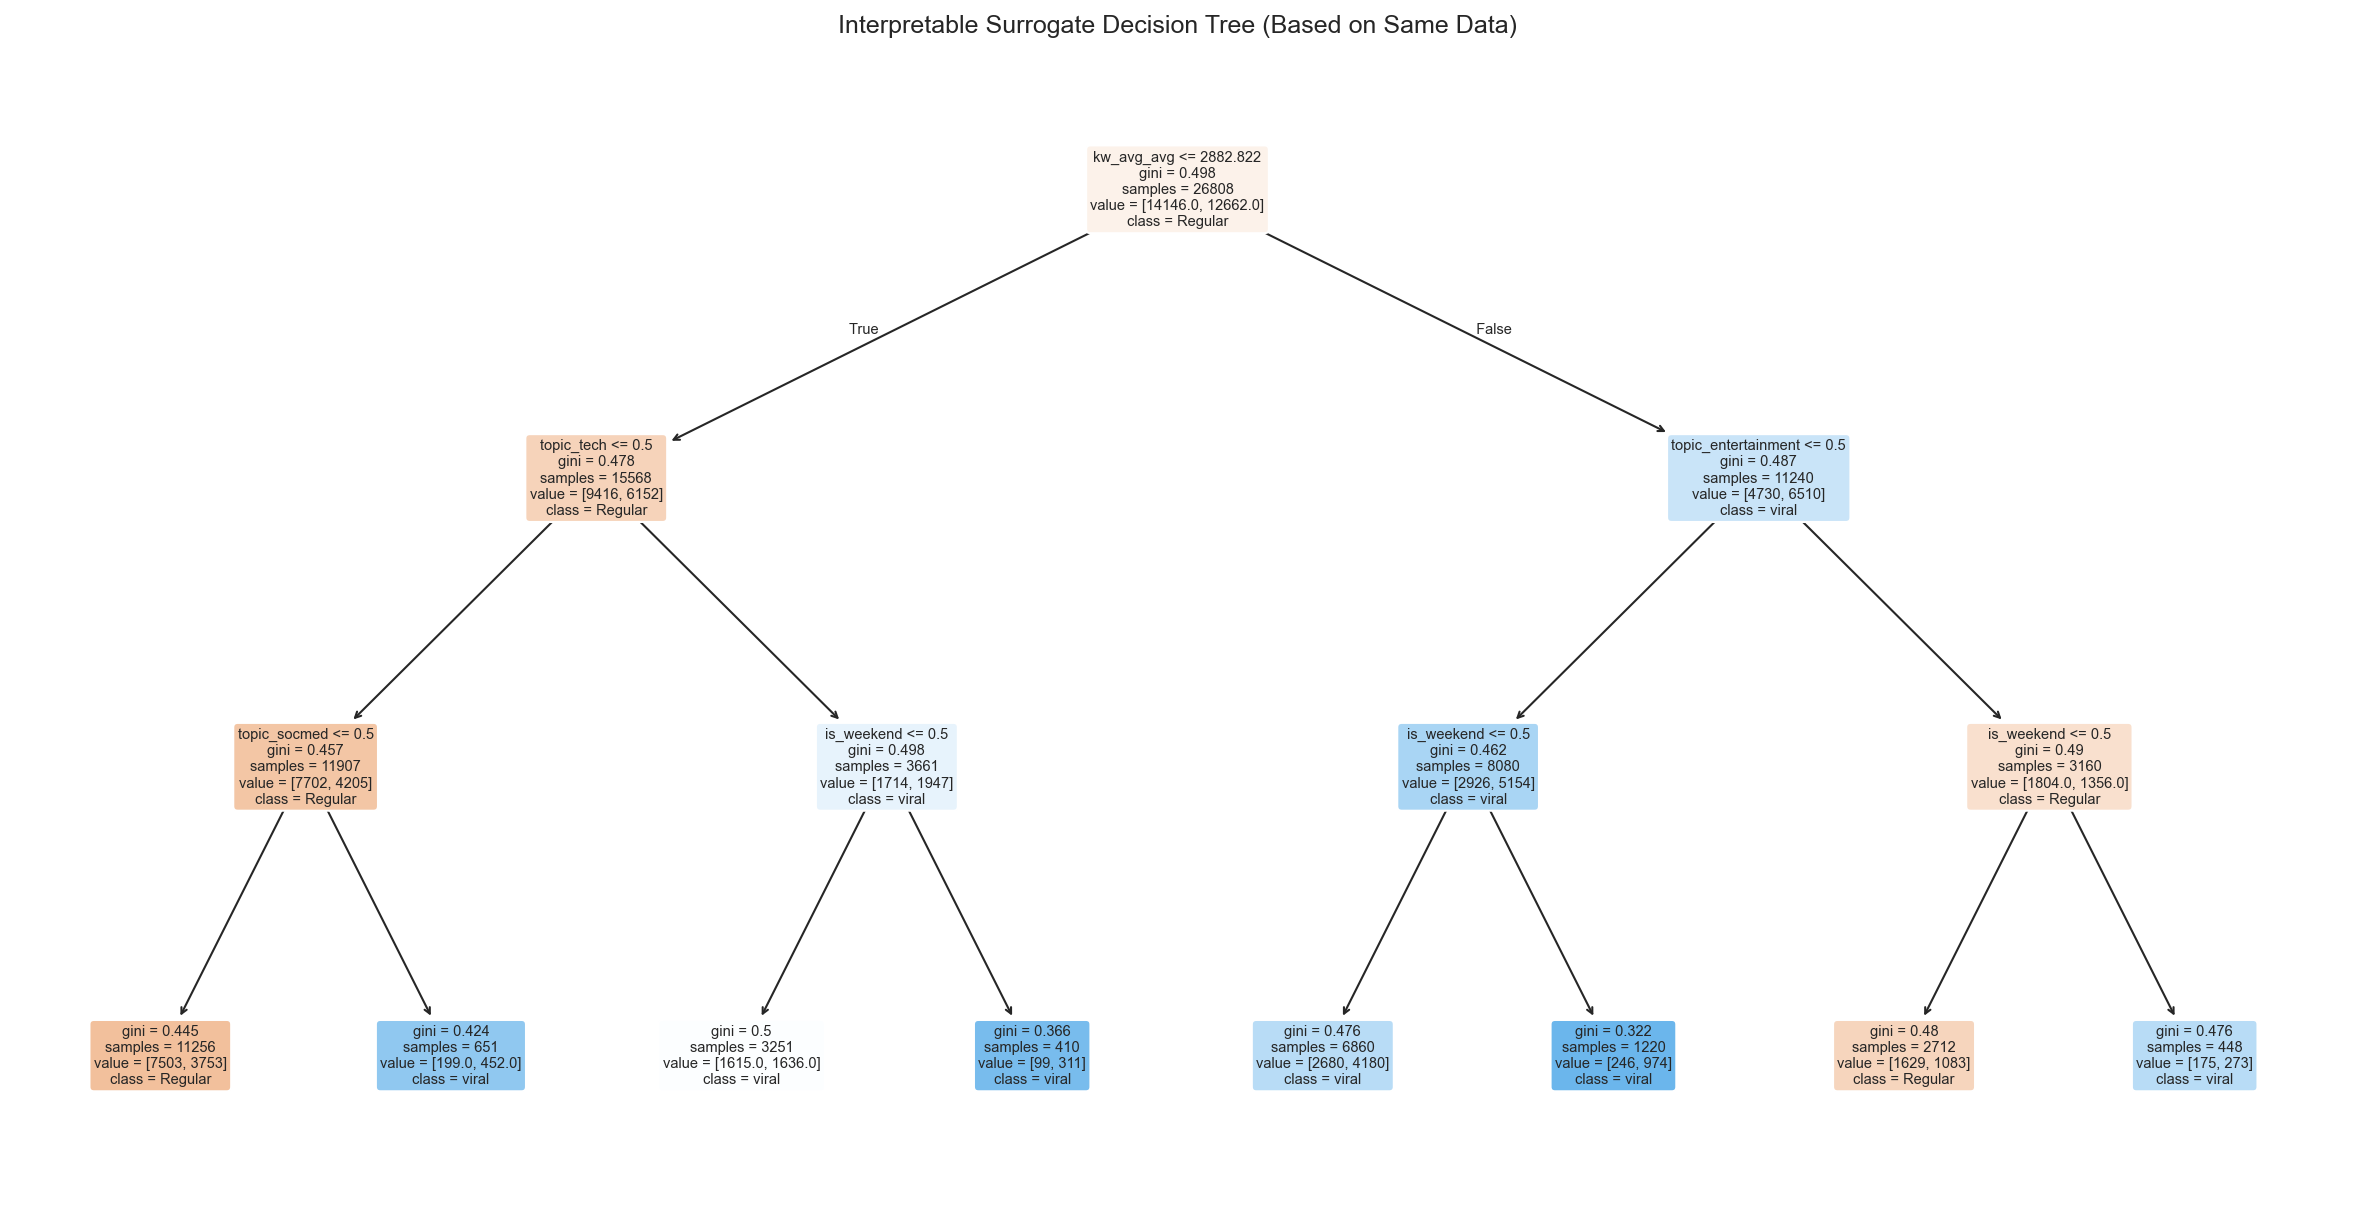

In [22]:
# ============================
# RANDOM FOREST + VISUALISATIONS
# ============================

# 1) -------- Prepare data --------
# Start from df2, which already has 'viral' defined
rf_df = df2.copy()

# Target variable
y = rf_df['viral']

# Drop columns that should NOT be used as predictors (only if they exist)
drop_cols = [c for c in ['url', 'shares', 'viral'] if c in rf_df.columns]
rf_df = rf_df.drop(columns=drop_cols)

# One-hot encode categorical variables (weekday, topic) if they exist
cat_cols = [c for c in ['weekday', 'topic'] if c in rf_df.columns]
rf_df = pd.get_dummies(rf_df, columns=cat_cols, drop_first=True)

X = rf_df

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2) -------- Train Random Forest --------
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)


rf_clf.fit(X_train, y_train)

print("Random Forest fitted!")
print("Train accuracy:", rf_clf.score(X_train, y_train))
print("Test accuracy:", rf_clf.score(X_test, y_test))

# 3) -------- Evaluation --------
y_pred = rf_clf.predict(X_test)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=['Regular', 'viral']))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))

# 4) -------- Visualise: simplified tree from Random Forest --------
# Pick one estimator from the forest
estimator = rf_clf.estimators_[0]

plt.figure(figsize=(20, 10), dpi=150)
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=['Regular', 'viral'],  # assuming 0 = Regular, 1 = viral
    filled=True,
    rounded=True,
    fontsize=7,
    max_depth=3        # << key: only show top 3 levels so it isn't insane
)
plt.title("Simplified Decision Tree from Random Forest (Top Levels Only)")
plt.show()

# 5) -------- Visualise: small surrogate Decision Tree --------
# (Purely for interpretation, not used for prediction)
viz_tree = DecisionTreeClassifier(
    max_depth=3,         # keep shallow for readability
    min_samples_leaf=50, # avoid tiny noisy leaves
    random_state=42
)

viz_tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10), dpi=150)
plot_tree(
    viz_tree,
    feature_names=X.columns,
    class_names=['Regular', 'viral'],
    filled=True,
    rounded=True,
    fontsize=7
)
plt.title("Interpretable Surrogate Decision Tree (Based on Same Data)")
plt.show()


/var/folders/85/8clyf79s3t3d0dzbfvhq0b8w0000gn/T/ipykernel_35351/256649109.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


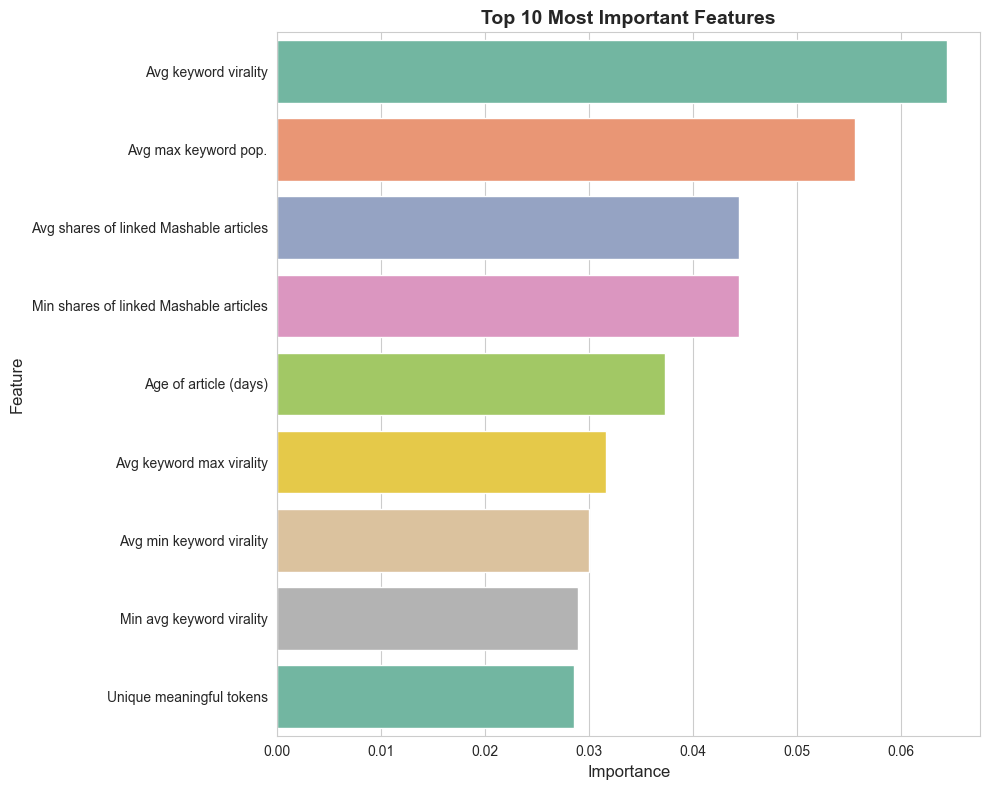


Top 10 Most Important Features:
                               feature  importance
                  Avg keyword virality    0.064427
                  Avg max keyword pop.    0.055652
Avg shares of linked Mashable articles    0.044481
Min shares of linked Mashable articles    0.044469
                 Age of article (days)    0.037355
              Avg keyword max virality    0.031677
                                   NaN    0.030514
              Avg min keyword virality    0.030024
              Min avg keyword virality    0.028903
              Unique meaningful tokens    0.028559


In [28]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance['feature'] = feature_importance["feature"].map(friendly_names)
# Plot top 10 features
top_n = 10
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(top_n),
    x='importance',
    y='feature',
    palette='Set2',
    ax=ax
)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))